# FSC

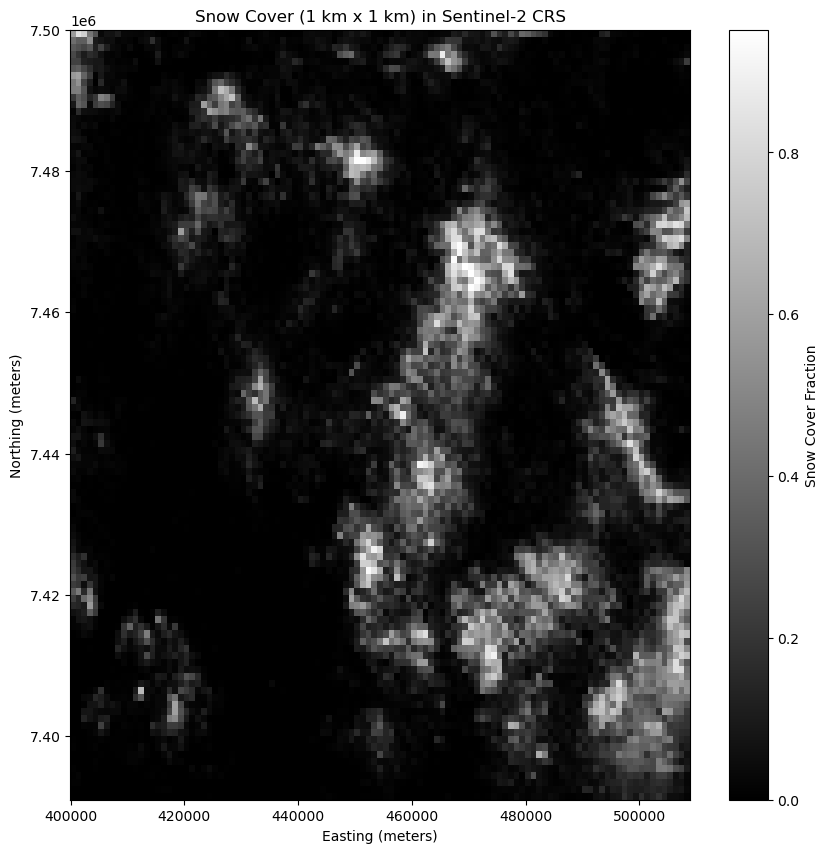

In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
from matplotlib.colors import ListedColormap

# Define paths for Sentinel-2 and DEM files
sentinel_path = "../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/"

band3_file = sentinel_path + "T35WMQ_20230515T095559_B03_20m.jp2"   # Green
band4_file = sentinel_path + "T35WMQ_20230515T095559_B04_20m.jp2"   # Red
band8a_file = sentinel_path + "T35WMQ_20230515T095559_B8A_20m.jp2"  # NIR
band11_file = sentinel_path + "T35WMQ_20230515T095559_B11_20m.jp2"  # SWIR
band12_file = sentinel_path + "T35WMQ_20230515T095559_B12_20m.jp2"  # SWIR

# Load Sentinel-2 bands and DEM data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs, src

band3, transform_band3, crs_band3, src_band3 = load_raster(band3_file)
band4, transform_band4, crs_band4, src_band4 = load_raster(band4_file)
band8a, transform_band8a, crs_band8a, src_band8a = load_raster(band8a_file)
band11, transform_band11, crs_band11, src_band11 = load_raster(band11_file)
band12, transform_band12, crs_band12, src_band12 = load_raster(band12_file)

# Create SWIR composite using bands 12, 8A, and 4 (for visualization)
def create_swir_composite(band12, band8a, band4):
    composite = np.dstack((band12, band8a, band4))
    return composite

# Create SWIR composite and mask (if needed)
swir_composite = create_swir_composite(band12, band8a, band4)

def create_mask(swir_composite):
    """
    Generates a mask where active areas are marked and inactive areas are set to NaN.
    """
    # Thresholds based on the description of the features
    water_marsh_mask = ((swir_composite[:, :, 0] < 1200))  # Dark in SWIR (water/marsh)
    cloud_mask = (swir_composite[:, :, 0] > 5000) & (swir_composite[:, :, 1] > 5000) & (swir_composite[:, :, 2] > 5000)  # White clouds
    
    # Combine all masks
    combined_mask = np.logical_or.reduce([water_marsh_mask, cloud_mask])
    #print(combined_mask)
    
    # Set mask to NaN where it's not active, and 1 where it is active
    combined_mask = np.where(combined_mask, 1, np.nan)
    
    return combined_mask
    
mask = create_mask(swir_composite)  # Mask generation (can be omitted if not needed)

def calculate_ndfsi(green_band, swir_band):
    """
    Calculate the NDFSI using Green (Band 3) and SWIR (Band 12).
    """
    ndfsi = (green_band - swir_band) / (green_band + swir_band)
    return ndfsi

ndfsi = calculate_ndfsi(band3, band11)

def apply_mask(ndfsi, mask):
    """
    Apply the mask to the NDFSI array. Masked areas will be set to NaN.
    """
    # Set NDFSI values where the mask is NaN to the NDFSI value, and everything else to NaN
    masked_ndfsi = np.where(np.isnan(mask), ndfsi, np.nan)
    return masked_ndfsi

masked_ndfsi = apply_mask(ndfsi, mask)

def apply_snow_threshold(ndfsi, threshold):
    """
    Apply a snow threshold to the NDFSI. 
    Below the threshold, set values to 1 (snow), and above it, set to 0 (no snow).
    """
    snow_mask = np.where(ndfsi <= threshold, 1, 0)
    return snow_mask

# Apply the threshold to create a binary snow mask
threshold = 0.4
snow_mask = apply_snow_threshold(masked_ndfsi, threshold)

def average_snow_cover_with_resize(snow_mask, transform, block_size_meters=1000):
    """
    Calculate the fractional snow cover in 1 km x 1 km blocks and resize the array to match the new resolution.
    Also, update the transform to match the resized array.
    """
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    # Calculate the number of pixels that correspond to the block size (1 km x 1 km)
    block_size_x = int(block_size_meters / pixel_size_x)
    block_size_y = int(block_size_meters / pixel_size_y)
    
    # Get the dimensions of the snow mask
    rows, cols = snow_mask.shape
    
    # Calculate the dimensions of the new array
    new_rows = rows // block_size_y
    new_cols = cols // block_size_x
    
    # Initialize an array for the averaged snow cover with the new dimensions
    resized_snow_cover = np.full((new_rows, new_cols), np.nan, dtype=float)
    
    # Iterate over the new dimensions
    for i in range(new_rows):
        for j in range(new_cols):
            # Extract the block from the original array
            block = snow_mask[i*block_size_y:(i+1)*block_size_y, j*block_size_x:(j+1)*block_size_x]
            
            # Calculate the mean of the block, ignoring NaNs
            if np.isnan(block).all():
                block_mean = np.nan
            else:
                block_mean = np.nanmean(block)
            
            # Assign the mean value to the resized array
            resized_snow_cover[i, j] = block_mean
    
    # Calculate the new transform for the resized array
    new_transform = rasterio.Affine(
        transform[0] * block_size_x, 0, transform[2],
        0, transform[4] * block_size_y, transform[5]
    )

    return resized_snow_cover, new_transform

averaged_snow_cover, new_transform = average_snow_cover_with_resize(snow_mask, transform_band3)

snow_left, snow_bottom = new_transform * (0, averaged_snow_cover.shape[0])
snow_right, snow_top = new_transform * (averaged_snow_cover.shape[1], 0)

plt.figure(figsize=(10, 10))
plt.imshow(averaged_snow_cover, cmap='gray', extent=(snow_left, snow_right, snow_bottom, snow_top), aspect='auto')
plt.colorbar(label='Snow Cover Fraction')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Snow Cover (1 km x 1 km) in Sentinel-2 CRS')
plt.show()

# DEM

In [2]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject
import matplotlib.pyplot as plt
from pyproj import Transformer

# Define the base directory containing DEM files
base_directory = '../data_store/data/korkeusmalli/hila_2m/etrs-tm35fin-n2000/'

def find_all_tif_files(base_dir):
    """
    Find all .tif files recursively in the given directory.
    """
    print("Searching for .tif files in the directory...")
    tif_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.tif'):
                full_path = os.path.join(root, file)
                tif_files.append(full_path)
                # print(f"Found: {full_path}")
    print(f"Total .tif files found: {len(tif_files)}")
    return tif_files

# Find all .tif files in the directory
dem_files = find_all_tif_files(base_directory)

def resample_and_merge_dems(dem_files):
    """
    Resample all DEM files to 10m resolution and merge them using rasterio's merge function.
    """
    datasets = []
    dem_crs = None

    for i, dem_file in enumerate(dem_files):
        # print(f"Processing file {i+1}/{len(dem_files)}: {dem_file}")
        with rasterio.open(dem_file) as src:
            if dem_crs == None:
                dem_crs = src.crs
            try:
                #resampled_data, resampled_transform, resampled_crs = resampled_data, src.transform*src.transform.scale(5,5), src.crs
                resampled_data = src.read(1, out_shape=(src.width//5, src.height//5), resampling=Resampling.average)

                memfile = MemoryFile()
                mem_dataset = memfile.open(
                    driver='GTiff',
                    height=resampled_data.shape[0],
                    width=resampled_data.shape[1],
                    count=1,
                    dtype=resampled_data.dtype,
                    crs=src.crs,
                    transform=src.transform*src.transform.scale(5,5)
                )
                mem_dataset.write(resampled_data, 1)
                # mem_dataset = create_memory_dataset(resampled_data, resampled_transform, resampled_crs)
                
                datasets.append(mem_dataset)
                # print(f"File {i+1} resampled and stored in memory.")
            except Exception as e:
                print(f"Error processing {dem_file}: {e}")

    # Merge the in-memory datasets
    try:
        mosaic, out_trans = merge(datasets)
        print("DEM merging completed.")
    except Exception as e:
        print(f"Error during merging: {e}")
        return None, None, None

    # Close all in-memory files
    for dataset in datasets:
        dataset.close()

    return mosaic, out_trans, dem_crs

merged_dem, merged_transform, dem_crs = resample_and_merge_dems(dem_files)

def reproject_dem_to_crs(src_array, src_transform, src_crs, dst_crs):
    """
    Reproject the DEM array to the target CRS (Sentinel-2 CRS).
    """
    width, height = src_array.shape[2], src_array.shape[1]

    # Calculate the bounding box from the source transform
    left, top = src_transform * (0, 0)
    right, bottom = src_transform * (width, height)
    
    # Calculate the transform and shape of the output array
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, left, bottom, right, top)

    # Prepare the destination array
    dst_array = np.empty((dst_height, dst_width), dtype=src_array.dtype)

    # Perform the reprojection
    reproject(
        source=src_array[0],
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    return dst_array, dst_transform

# Reproject the merged DEM to match the Sentinel-2 CRS (crs_band3)
reprojected_dem, reprojected_transform = reproject_dem_to_crs(merged_dem, merged_transform, dem_crs, crs_band3)

dem_left, dem_bottom = reprojected_transform * (0, reprojected_dem.shape[0])
dem_right, dem_top = reprojected_transform * (reprojected_dem.shape[1], 0)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(reprojected_dem, cmap='terrain', extent=(dem_left, dem_right, dem_bottom, dem_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

Searching for .tif files in the directory...
Total .tif files found: 324
DEM merging completed.


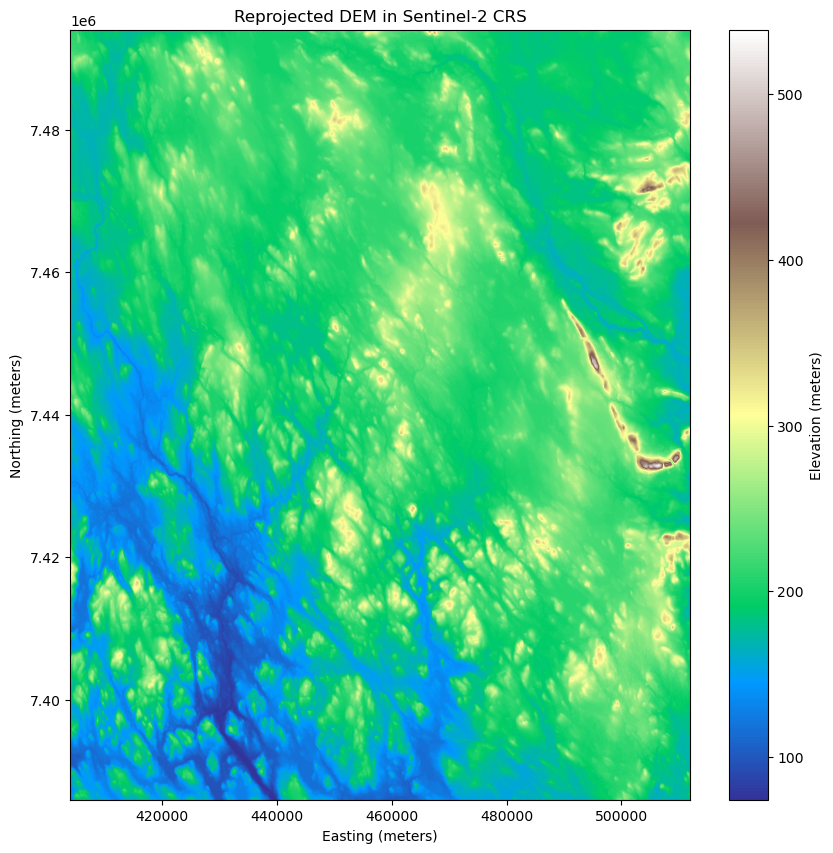

In [3]:
def reproject_dem_to_crs(src_array, src_transform, src_crs, dst_crs):
    """
    Reproject the DEM array to the target CRS (Sentinel-2 CRS).
    """
    width, height = src_array.shape[2], src_array.shape[1]

    # Calculate the bounding box from the source transform
    left, top = src_transform * (0, 0)
    right, bottom = src_transform * (width, height)
    
    # Calculate the transform and shape of the output array
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, left, bottom, right, top)

    # Prepare the destination array
    dst_array = np.empty((dst_height, dst_width), dtype=src_array.dtype)

    # Perform the reprojection
    reproject(
        source=src_array[0],
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    return dst_array, dst_transform

# Reproject the merged DEM to match the Sentinel-2 CRS (crs_band3)
reprojected_dem, reprojected_transform = reproject_dem_to_crs(merged_dem, merged_transform, dem_crs, crs_band3)

dem_left, dem_bottom = reprojected_transform * (0, reprojected_dem.shape[0])
dem_right, dem_top = reprojected_transform * (reprojected_dem.shape[1], 0)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(reprojected_dem, cmap='terrain', extent=(dem_left, dem_right, dem_bottom, dem_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Combination

(10496, 10301) (105, 104)


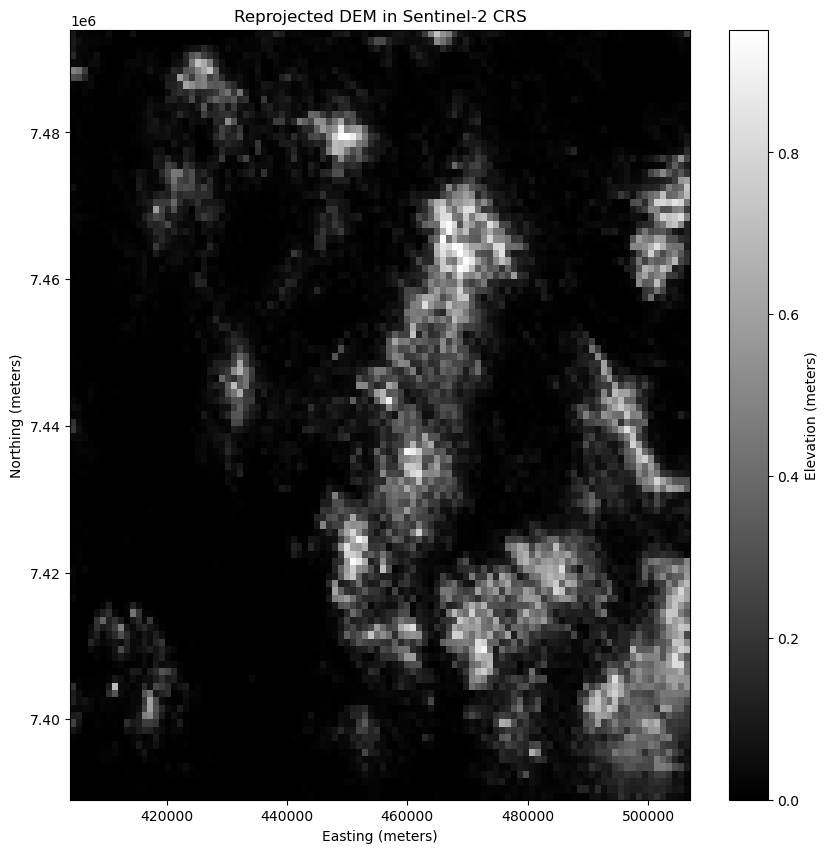

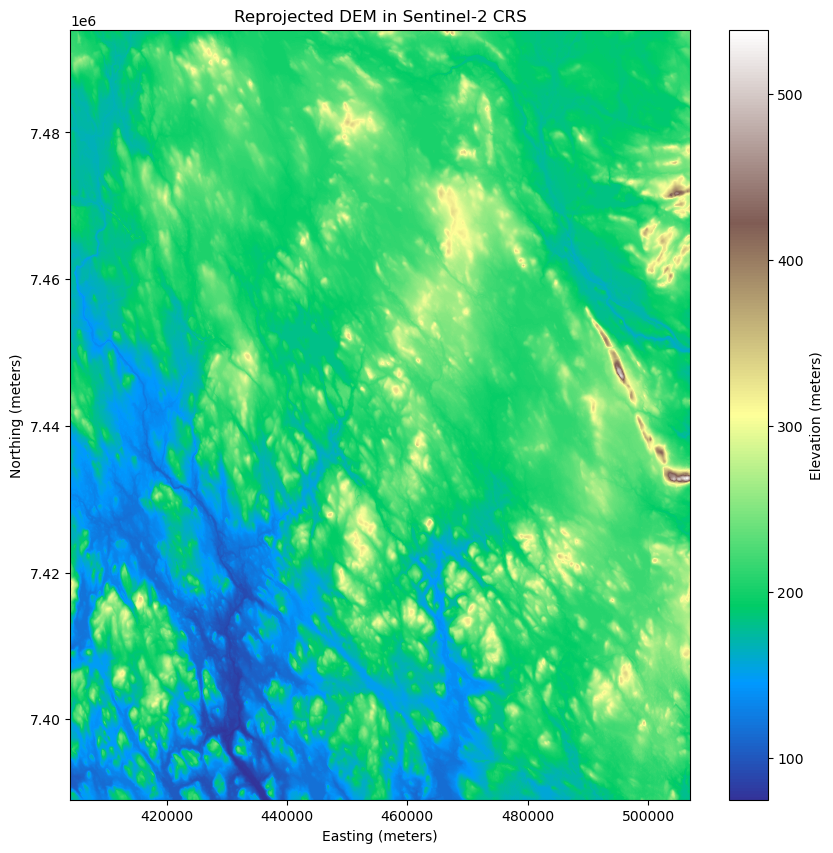

In [10]:
import numpy as np
import rasterio

def crop_to_overlap(array1, transform1, array2, transform2):
    """
    Crops two arrays to their overlapping area and returns the cropped arrays along with their updated transforms.

    Parameters:
    array1 (np.ndarray): The first array to crop.
    transform1 (Affine): The affine transformation of the first array.
    array2 (np.ndarray): The second array to crop.
    transform2 (Affine): The affine transformation of the second array.

    Returns:
    tuple: Cropped arrays and their corresponding updated transforms.
           (cropped_array1, new_transform1, cropped_array2, new_transform2)
    """
    # Get the bounding coordinates of both arrays
    left1, bottom1 = transform1 * (0, array1.shape[0])
    right1, top1 = transform1 * (array1.shape[1], 0)
    
    left2, bottom2 = transform2 * (0, array2.shape[0])
    right2, top2 = transform2 * (array2.shape[1], 0)

    # Calculate the overlapping bounds
    overlap_left = max(left1, left2)
    overlap_right = min(right1, right2)
    overlap_top = min(top1, top2)
    overlap_bottom = max(bottom1, bottom2)

    # If there's no overlap, return None
    if overlap_left >= overlap_right or overlap_bottom >= overlap_top:
        raise ValueError("The two arrays do not overlap.")

    # Calculate the new row and column indices for array1
    row_start1, col_start1 = ~transform1 * (overlap_left, overlap_top)
    row_end1, col_end1 = ~transform1 * (overlap_right, overlap_bottom)

    # Ensure indices are integers within the array bounds
    row_start1 = max(0, int(np.floor(row_start1)))
    col_start1 = max(0, int(np.floor(col_start1)))
    row_end1 = min(array1.shape[0], int(np.ceil(row_end1)))
    col_end1 = min(array1.shape[1], int(np.ceil(col_end1)))

    # Crop array1
    cropped_array1 = array1[row_start1:row_end1, col_start1:col_end1]

    # Update the transform for the cropped array1
    new_transform1 = transform1 * rasterio.Affine.translation(col_start1, row_start1)

    # Calculate the new row and column indices for array2
    row_start2, col_start2 = ~transform2 * (overlap_left, overlap_top)
    row_end2, col_end2 = ~transform2 * (overlap_right, overlap_bottom)

    # Ensure indices are integers within the array bounds
    row_start2 = max(0, int(np.floor(row_start2)))
    col_start2 = max(0, int(np.floor(col_start2)))
    row_end2 = min(array2.shape[0], int(np.ceil(row_end2)))
    col_end2 = min(array2.shape[1], int(np.ceil(col_end2)))

    # Crop array2
    cropped_array2 = array2[row_start2:row_end2, col_start2:col_end2]

    # Update the transform for the cropped array2
    new_transform2 = transform2 * rasterio.Affine.translation(col_start2, row_start2)

    return cropped_array1, new_transform1, cropped_array2, new_transform2


dem_cropped, dem_transform_cropped, snow_cropped, snow_transform_cropped = crop_to_overlap(
                                                                                reprojected_dem,
                                                                                reprojected_transform,
                                                                                averaged_snow_cover,
                                                                                new_transform)

c_left, c_bottom = reprojected_transform * (0, dem_cropped.shape[0])
c_right, c_top = reprojected_transform * (dem_cropped.shape[1], 0)

# Plot the Snow Cover
plt.figure(figsize=(10, 10))
plt.imshow(snow_cropped, cmap='gray', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(dem_cropped, cmap='terrain', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Topography

(105, 104)


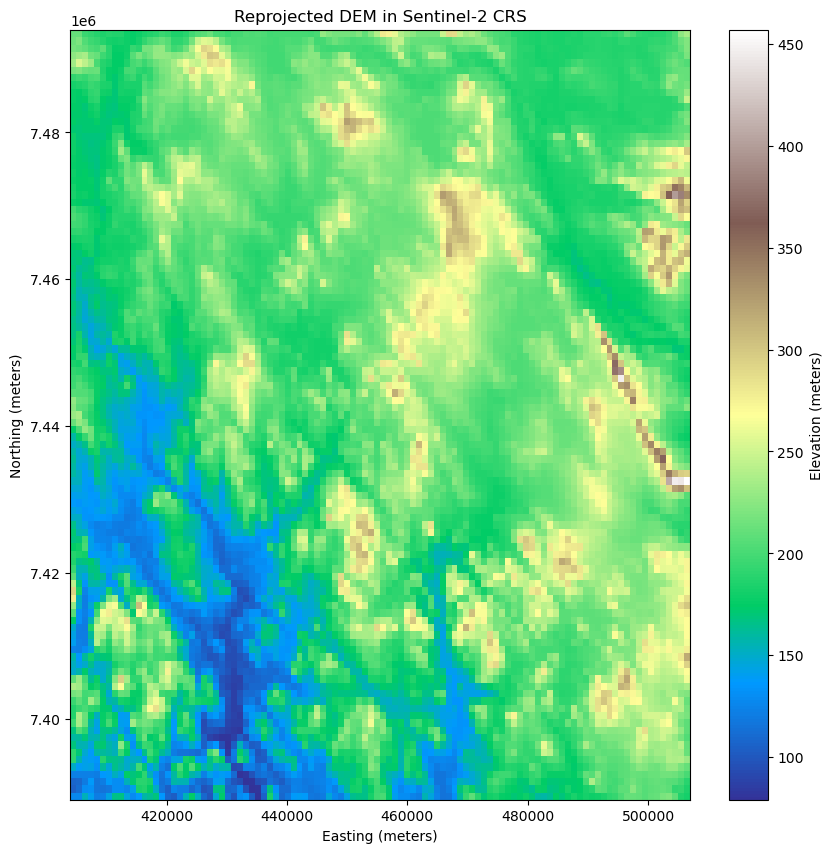

In [42]:
def averaged_to_snow_resolution(array, snow_shape):
    """
    Averages the input array down to match the shape of the snow cover array.

    Parameters:
    array (np.ndarray): The input array to be downsampled.
    snow_shape (tuple): The target shape of the snow cover array (height, width).

    Returns:
    np.ndarray: The resampled array with the same shape as the snow cover array.
    """
    # Get the shape of the input array
    array_height, array_width = array.shape
    
    # Get the target snow grid shape
    snow_height, snow_width = snow_shape
    
    # Calculate the bin size for averaging
    bin_size_y = array_height // snow_height
    bin_size_x = array_width // snow_width
    
    # Reshape and average the input array to match the snow cover shape
    resampled_array = array[:bin_size_y * snow_height, :bin_size_x * snow_width]
    resampled_array = resampled_array.reshape(snow_height, bin_size_y, snow_width, bin_size_x).mean(axis=(1, 3))
    
    return resampled_array

dem_cropped_resampled = averaged_to_snow_resolution(dem_cropped, snow_cropped.shape)
                                              #crs_band3, crs_band3)
# print(dem_cropped_resampled.shape)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(dem_cropped_resampled, cmap='terrain', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

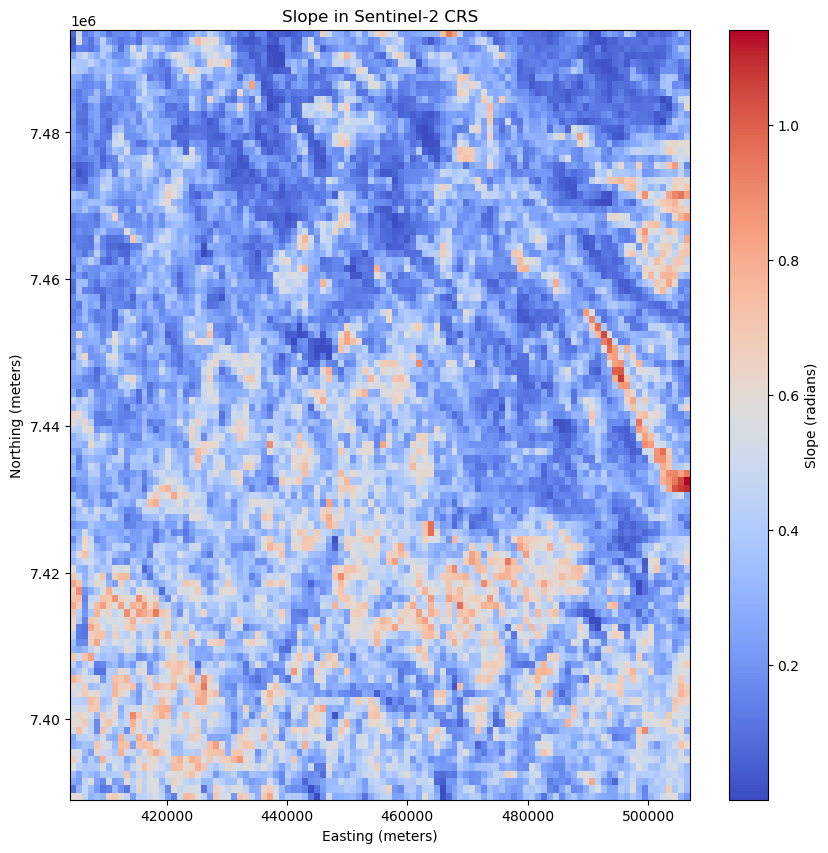

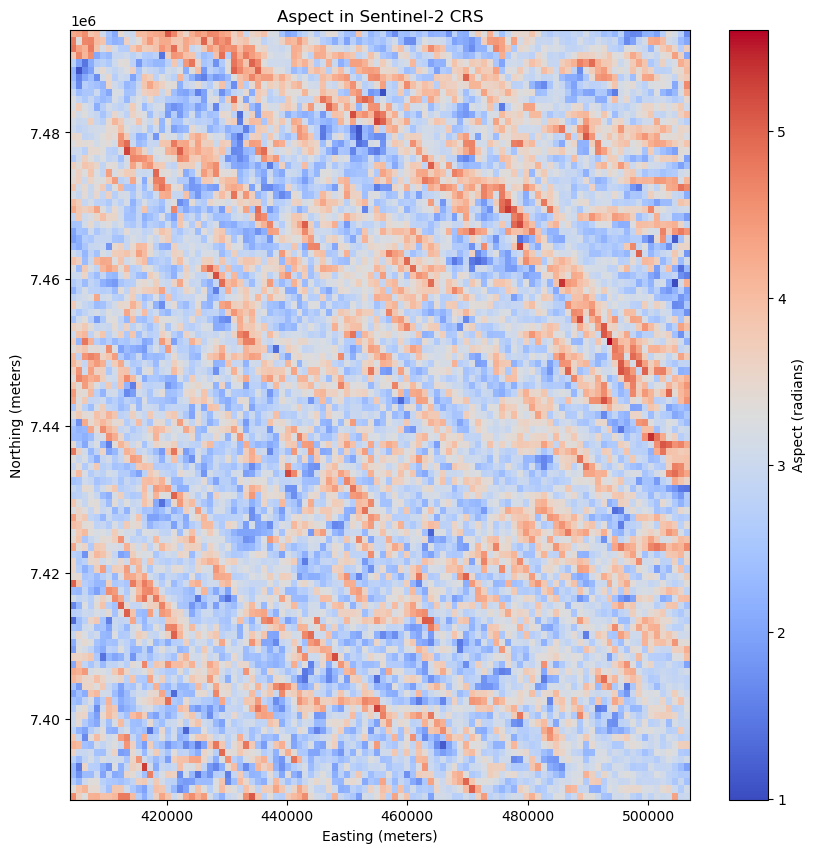

In [46]:
def compute_aspect_slope(dem_cropped):
    """
    Computes the aspect and slope of each pixel in the DEM.

    Parameters:
    dem_cropped (np.ndarray): The cropped DEM array.

    Returns:
    tuple: Two arrays of the same shape as dem_cropped: (aspect, slope).
           - aspect: The aspect in degrees (0 to 360).
           - slope: The slope in degrees.
    """
    # Calculate the gradients (difference in elevation) in x and y directions
    dz_dx = np.gradient(dem_cropped, axis=1)  # Gradient along x-axis (columns)
    dz_dy = np.gradient(dem_cropped, axis=0)  # Gradient along y-axis (rows)

    # Calculate the slope in radians
    slope_radians = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))

    # Calculate the aspect in radians
    aspect_radians = np.arctan2(-dz_dy, -dz_dx)
    aspect_radians = np.where(aspect_radians < 0, 2 * np.pi + aspect_radians, aspect_radians)

    return slope_radians, aspect_radians

slope, aspect = compute_aspect_slope(dem_cropped)

aspect_resampled = averaged_to_snow_resolution(aspect, snow_cropped.shape)
slope_resampled = averaged_to_snow_resolution(slope, snow_cropped.shape)

# Plot the slope
plt.figure(figsize=(10, 10))
plt.imshow(slope_resampled, cmap='coolwarm', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Slope (radians)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Slope in Sentinel-2 CRS')
plt.show()

# Plot the aspect
plt.figure(figsize=(10, 10))
plt.imshow(aspect_resampled, cmap='coolwarm', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Aspect (radians)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Aspect in Sentinel-2 CRS')
plt.show()

<xarray.Dataset> Size: 220kB
Dimensions:  (y: 105, x: 104)
Coordinates:
  * y        (y) float64 840B 7.496e+06 7.495e+06 ... 7.393e+06 7.392e+06
  * x        (x) float64 832B 4.05e+05 4.06e+05 4.07e+05 ... 5.07e+05 5.08e+05
Data variables:
    snow     (y, x) float64 87kB 0.086 0.0212 0.0224 ... 0.0512 0.0388 0.016
    dem      (y, x) float32 44kB 211.5 211.4 194.9 192.4 ... 207.9 185.5 181.6
    slope    (y, x) float32 44kB 0.0921 0.4967 0.1301 ... 0.5668 0.3087 0.2183
    aspect   (y, x) float32 44kB 4.233 4.33 4.574 3.849 ... 4.33 2.962 3.01


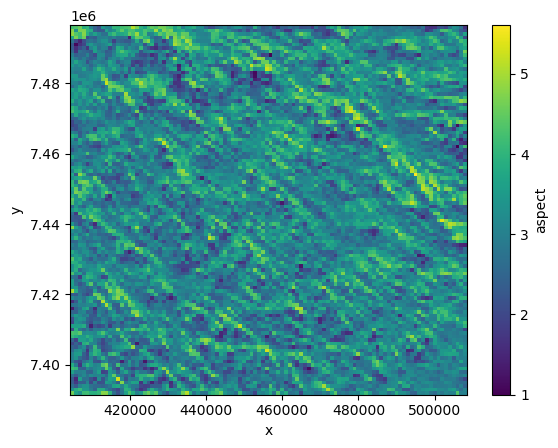

In [55]:
import xarray as xr
import numpy as np

def create_combined_xarray(snow, dem, slope, aspect, snow_transform):
    """
    Combines snow, dem, slope, and aspect arrays into a single xarray Dataset with four layers and coordinates.

    Parameters:
    snow (np.ndarray): Snow cover array (2D).
    dem (np.ndarray): Resampled DEM array (2D).
    slope (np.ndarray): Resampled slope array (2D).
    aspect (np.ndarray): Resampled aspect array (2D).
    snow_transform (Affine): The affine transformation of the snow cover array.

    Returns:
    xr.Dataset: An xarray Dataset with four layers: 'snow', 'dem', 'slope', and 'aspect', with coordinates.
    """
    # Ensure all arrays have the same shape
    assert snow.shape == dem.shape == slope.shape == aspect.shape, "All arrays must have the same shape."

    # Get the dimensions of the arrays
    height, width = snow.shape

    # Generate coordinates based on the snow_transform
    x_coords = snow_transform.c + np.arange(width) * snow_transform.a
    y_coords = snow_transform.f + np.arange(height) * snow_transform.e

    # Create a DataArray for each variable
    snow_da = xr.DataArray(snow, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="snow")
    dem_da = xr.DataArray(dem, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="dem")
    slope_da = xr.DataArray(slope, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="slope")
    aspect_da = xr.DataArray(aspect, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="aspect")

    # Combine into a single Dataset
    dataset = xr.Dataset({"snow": snow_da, "dem": dem_da, "slope": slope_da, "aspect": aspect_da})

    return dataset

# Example usage
combined_dataset = create_combined_xarray(snow_cropped, dem_cropped_resampled, slope_resampled, aspect_resampled, snow_transform_cropped)

# Display the combined xarray dataset
print(combined_dataset)

combined_dataset.aspect.plot()

combined_dataset.to_netcdf('sodankyla_topography.nc')

# Load NetCDF Topography from here

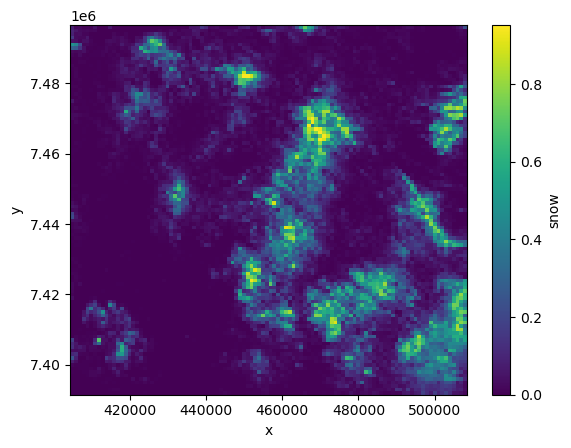

In [60]:
import xarray as xr
import numpy as np

sodankyla_topography = xr.load_dataset('sodankyla_topography.nc')

sodankyla_topography.snow.plot()

In [63]:
import numpy as np
import xarray as xr
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def calibrate_model(dataset, distance_threshold=5000):
    """
    Calibrates the coefficients a, b, and c based on the training area of the dataset.

    Parameters:
    dataset (xr.Dataset): The xarray dataset containing 'snow', 'dem', 'slope', and 'aspect'.
    distance_threshold (float): The distance threshold within which to consider neighboring pixels (in meters).

    Returns:
    tuple: The calibrated coefficients (a, b, c).
    """
    # Extract the variables from the dataset
    snow = dataset['snow'].values
    dem = dataset['dem'].values
    slope = dataset['slope'].values
    aspect = dataset['aspect'].values
    x_coords = dataset['x'].values
    y_coords = dataset['y'].values
    
    # Dimensions
    height, width = snow.shape

    # Create a mask for the test area (top-left quarter)
    test_mask = np.zeros_like(snow, dtype=bool)
    test_mask[:height // 2, :width // 2] = True

    # Indices for training area
    train_indices = np.argwhere(~test_mask)
    test_indices = np.argwhere(test_mask)

    print(f"Training on {len(train_indices)} pixels, testing on {len(test_indices)} pixels.")

    # Define the function to minimize (RMSE)
    def objective(params):
        a, b, c = params
        predictions = []
        targets = []

        print("Starting objective calculation...")

        for idx_count, idx in enumerate(train_indices):
            i, j = idx
            snow_A = snow[i, j]
            dem_A = dem[i, j]
            slope_A = slope[i, j]
            aspect_A = aspect[i, j]

            # Find neighboring pixels within the distance threshold
            neighbors = [
                (ii, jj) for ii in range(height) for jj in range(width)
                if not test_mask[ii, jj] and ((x_coords[jj] - x_coords[j])**2 + (y_coords[ii] - y_coords[i])**2) <= distance_threshold**2
            ]

            if idx_count % 100 == 0:
                print(f"Processed {idx_count} out of {len(train_indices)} pixels in training area...")

            for ii, jj in neighbors:
                snow_B = snow[ii, jj]
                dem_B = dem[ii, jj]
                slope_B = slope[ii, jj]
                aspect_B = aspect[ii, jj]

                # Calculate predicted snow_B
                predicted_snow_B = (snow_A +
                                    a * (dem_B - dem_A) +
                                    b * (np.cos(slope_B) - np.cos(slope_A)) -
                                    c * (np.exp(np.sin(aspect_B)) - np.exp(np.sin(aspect_A))))

                # Collect the prediction and the actual value
                predictions.append(predicted_snow_B)
                targets.append(snow[ii, jj])
        
        print("Finished calculating objective.")
        print(mean_squared_error(targets, predictions))
        return mean_squared_error(targets, predictions)

    # Initial guess for coefficients
    initial_guess = [0.0, 0.0, 0.0]
    print("Starting optimization...")
    result = minimize(objective, initial_guess, method='L-BFGS-B')
    print("Optimization complete.")

    # Calibrated coefficients
    a, b, c = result.x
    print(f"Calibrated coefficients: a={a}, b={b}, c={c}")
    return a, b, c

# Calibrate the model
a, b, c = calibrate_model(sodankyla_topography)

Training on 8216 pixels, testing on 2704 pixels.
Starting optimization...
Starting objective calculation...
Processed 0 out of 8216 pixels in training area...
Processed 100 out of 8216 pixels in training area...
Processed 200 out of 8216 pixels in training area...
Processed 300 out of 8216 pixels in training area...
Processed 400 out of 8216 pixels in training area...
Processed 500 out of 8216 pixels in training area...
Processed 600 out of 8216 pixels in training area...
Processed 700 out of 8216 pixels in training area...
Processed 800 out of 8216 pixels in training area...
Processed 900 out of 8216 pixels in training area...
Processed 1000 out of 8216 pixels in training area...
Processed 1100 out of 8216 pixels in training area...
Processed 1200 out of 8216 pixels in training area...
Processed 1300 out of 8216 pixels in training area...
Processed 1400 out of 8216 pixels in training area...
Processed 1500 out of 8216 pixels in training area...
Processed 1600 out of 8216 pixels in tra

KeyboardInterrupt: 